<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [211]:
%%capture
pip install pyswarms

In [212]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [213]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'
DIAS_OBSERVADOS = 600

In [214]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [215]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [216]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [217]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [218]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - math.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [219]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [220]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [221]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [222]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [223]:
# Defina o dicionário de tipos de dados
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/Cenarios/cenario01.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/Cenarios/cenario02.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/Cenarios/cenario03.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/Cenarios/cenario04.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912


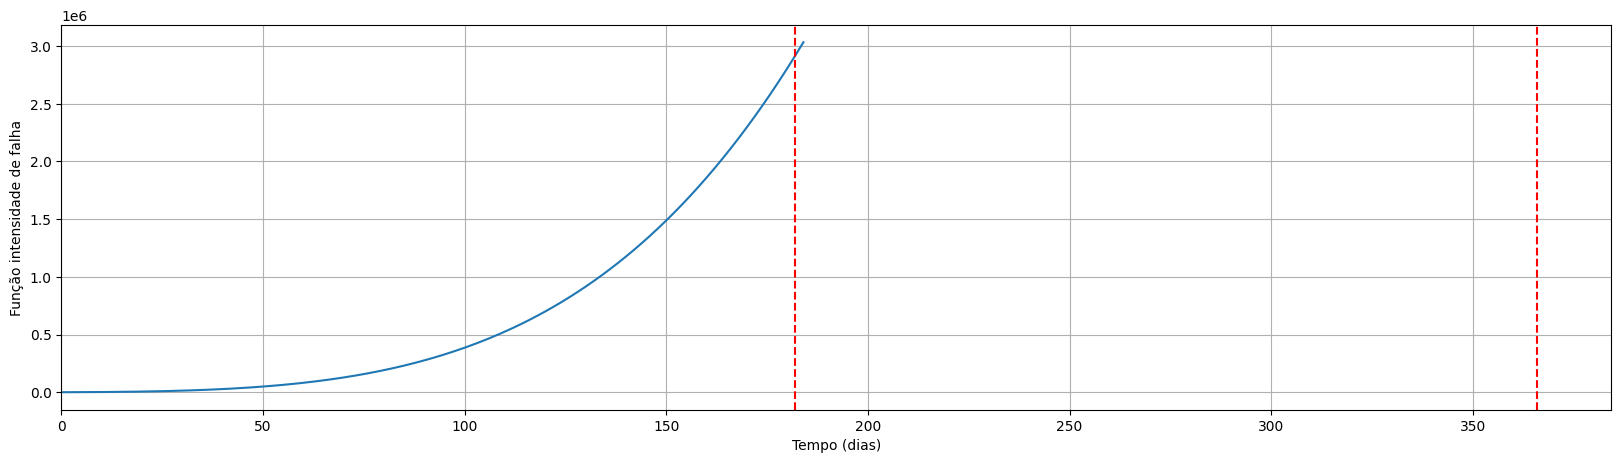

Fator ajuste:  [0.8646647167633873, 0.8646647167633873, 0.8646647167633873, 0.8646647167633873, 0.8646647167633873, 0.6321205588285577, 0.6321205588285577, 0.8646647167633873, 0.6321205588285577, 0.8646647167633873, 0.6321205588285577, 0.8646647167633873, 0.8646647167633873, 0.8646647167633873]


In [224]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [225]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [226]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-24 22:28:06,480 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=6.05e+10



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 30, 87, 208, 211, 246, 322, 356, 404, 555, 595, 647, 676, 699]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 7776.000000000001, 279379.5824355922, 50847655.63253125, 50872997.31650613, 55769223.39061206, 67903476.973948, 179836902.83573276, 189579181.29206246, 448612516.79162323, 1490327407.9308782, 1796304035.9962122, 1826352026.8064566, 1995661294.8182278, -1227958370.9803658]
Custo =  315311141239.67365


Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 5, 51, 104, 150, 204, 216, 262, 546

pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=6.05e+10



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 45, 65, 97, 140, 173, 323, 354, 368, 482, 522, 542, 592, 609, 637, 710]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 59049.00000000001, 62914.6862427975, 627257.4342183623, 986963.1753079563, 2249840.2170755975, 342729995.95198417, 359308258.1905681, 367293543.8735663, 661383655.3962362, 1275544030.1091294, 1329119147.0782566, 1367541742.315702, 1439059378.251285, 1583890743.9627397, 2235237305.2682467, 2203389980.2645965]
Custo =  173653216928.82834


Número de ciclos de 

pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=6.05e+10



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 49, 74, 95, 144, 154, 251, 278, 340, 380, 596, 629, 645, 699]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 90392.07968000001, 100521.11561909085, 439449.0545150407, 983528.4204847927, 1166966.730723769, 78976551.68385197, 84573806.64061148, 249692363.71427524, 279125018.78789926, 2086542278.1766903, 3168518831.867795, 3252789754.0697412, 5917853911.794778, 5888511574.9517975]
Custo =  402110093342.9468


Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 50, 74, 103, 178, 255, 281, 327, 409, 590

pyswarms.single.global_best:  61%|██████    |61/100, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 49, 78, 98, 139, 152, 198, 268, 334, 540, 639, 663, 706]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 108766.73439947092, 475036.67314698175, 787672.3327573065, 1023035.7041895415, 4366916.912104386, 22739117.260053657, 185976931.91763222, 3720491795.3089337, 4369168186.53399, 4512945623.033879, 4571477304.920821, 1075621334.127162]
Custo =  267587213167.43317


Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 27, 50, 81, 97, 145, 164, 277, 336, 388, 514, 540, 636, 669]
Severidade para cada subsiste

pyswarms.single.global_best:  79%|███████▉  |79/100, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 48, 78, 102, 203, 259, 320, 349, 367, 517, 642, 689, 694]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 81537.26976000001, 102253.19277593671, 616458.1629205536, 9904997.596742114, 21356875.180034123, 28720019.606224746, 117408955.33793676, 119084492.23390232, 706545489.1819408, 4928828124.764817, 4989282403.162636, 4994051590.070308, 1960505791.554697]
Custo =  303195363631.11523


Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 22, 49, 78, 96, 186, 268, 277, 328, 337, 377, 518, 637]
Severidade para cada subsistem

pyswarms.single.global_best:  87%|████████▋ |87/100, best_cost=6.05e+10



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 6, 47, 70, 98, 134, 169, 209, 260, 328, 336, 400, 525, 540, 589, 637, 686, 694]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 2.4883200000000003, 40896.08349048313, 54330.80380676457, 565800.1313839777, 771832.960468717, 2040690.6035562865, 5306330.424675624, 51635702.93316225, 86632748.75480461, 108361537.30125394, 436586296.2205467, 892263057.0276811, 1163382596.4476924, 1200014320.3493497, 1462852743.0103471, 182107795

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=6.05e+10
2023-09-24 22:28:07,929 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44186252 1.57688835 5.15883226 2.76374895 0.74595216 5.84753906
 0.73028102 3.93683297 0.75552083 1.77662221 5.89204633 4.41389398
 0.60587255 0.88903504 0.51268283 4.37546279 3.12784885 4.4252052
 2.90901494 2.9009263  6.3996537  5.51245874 0.47752188 3.56566025]
2023-09-24 22:28:07,932 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 47, 68, 95, 140, 254, 290, 333, 396, 525, 540, 585, 637, 692]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 73390.40224000001, 78293.78299512318, 513772.11517307704, 919176.9159817076, 40538919.86104991, 49887669.121354625, 156822526.36543205, 218287204.24462077, 697655723.6389216, 968775263.0589329, 1000368938.862012, 1288565398.004172, 1711339655.5089562, 1683557712.5914226]
Custo =  160481695625.42618


Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 47, 70, 96, 126, 205, 248, 284, 306, 352,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:07,954 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.45112784 1.57652556 5.15884629 2.76370294 0.75080212 5.84853635
 0.50028531 3.94379291 0.75599266 1.77694651 5.89088631 1.17039142
 0.60516802 0.89435635 0.51897149 4.37547157 3.12529742 4.42538837
 2.91009599 2.90092952 6.40033572 5.52591562 5.99681247 3.49879212]




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 22, 47, 73, 98, 126, 251, 318, 405, 510, 571, 639, 699]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1649.16224, 7134.191717299556, 55292.133551676874, 511445.78258838376, 608520.599965422, 47812279.90228077, 78529947.75205383, 542632691.5821722, 857393049.1985432, 2180047351.776593, 2260474900.597306, 2746596978.4591856, 2717254641.616205]
Custo =  161824928659.24536


2023-09-24 22:28:07,957 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:07,991 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.45400343 1.57634098 5.15888386 2.7637053  0.75059665 5.84821032
 3.80961464 3.94366133 0.75593167 1.77643651 5.89283019 4.02098219
 0.60378    0.89743443 0.51231423 4.37547003 3.12400003 4.42512644
 2.90931084 2.90097067 6.39938161 5.5196913  1.83470904 3.49853086]
2023-09-24 22:28:07,993 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 7, 47, 68, 95, 174, 195, 248, 338, 364, 399, 600, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 5.378240000000001, 36841.91721428822, 62686.20153000077, 498164.53370795463, 3728498.3722550017, 4805382.867634506, 7434773.808286978, 28018837.780376494, 122654911.97125295, 152871890.01892653, 5347292359.603529, 6788027946.115, 5573719104.054646]
Custo =  381968142318.55884


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,009 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.45628352 1.57629138 5.15891422 2.76371906 0.74975459 5.84786505
 0.51240712 3.9418084  0.7558492  1.77601401 5.89455849 6.66116796
 0.60272383 0.89817273 0.5063623  4.37546689 3.12312593 4.42489338
 2.90858445 2.90100733 6.39859604 5.51292697 5.48583198 3.51624135]
2023-09-24 22:28:08,010 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 47, 64, 243, 324, 350, 363, 391, 643, 686]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 73390.40224000001, 75613.37531072355, 156945779.235117, 171262362.2906319, 252040536.29536173, 299783059.01535505, 321394216.30754846, 3411637661.1852913, 5395126640.269539, 5368672641.041018]
Custo =  269216471865.10928


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,024 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.455427   1.57635837 5.15892316 2.76373573 0.74863827 5.84750843
 5.28283088 3.93958263 0.75568625 1.77581299 5.8958345  1.8989404
 0.60266515 0.8975593  0.50265554 4.37546332 3.12268228 4.42469353
 2.90803279 2.90103344 6.39819277 5.50681974 3.01599951 3.5462435 ]
2023-09-24 22:28:08,027 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 47, 60, 204, 272, 366, 480, 534, 645, 668]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 73390.40224000001, 74257.55633128747, 61181019.851411454, 67150806.99325576, 400821589.1769384, 491433876.4680587, 521650681.6744425, 1307061387.8905783, 1448633503.63704, 1426211854.7442079]
Custo =  75914752281.55798


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,039 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.45095708 1.57642495 5.15891637 2.7637527  0.74694101 5.8471966
 3.64347011 3.93701365 0.75549143 1.77577933 5.89687941 4.5668049
 0.60294538 0.89634862 0.50103855 4.37545995 3.12240883 4.42465645
 2.90770219 2.90104055 6.39801727 5.50204259 0.95218265 3.57700156]
2023-09-24 22:28:08,040 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 47, 142, 175, 237, 482, 527, 647]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 73390.40224000001, 3497114.9018412745, 9657850.463031476, 12999996.00573534, 1305780139.3454006, 1423475514.7849505, 2310631047.465502, 2147556722.0906906]
Custo =  76131724049.90277


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44469686 1.57649843 5.15890635 2.76376742 0.74532453 5.84693027
 2.46456361 3.93465163 0.75532352 1.77596392 5.89734215 6.95879244
 0.60376015 0.89328091 0.5022806  4.37545731 3.12243868 4.4246633
 2.90760734 2.90104063 6.39793894 5.4981839  6.74715164 3.60402881]
2023-09-24 22:28:08,054 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 47, 174, 233, 483, 525, 648, 686]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 73390.40224000001, 13572034.675274003, 47971160.093848616, 1411103777.2712226, 1518167765.9416533, 2442645330.3569613, 2712389801.7662344, 2685935802.5377126]
Custo =  94459121334.46114


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,071 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43893418 1.57659747 5.15888202 2.76377798 0.74400983 5.84680916
 1.82706731 3.93298657 0.75520135 1.77622398 5.8971628  1.49219598
 0.60487431 0.88989981 0.50641166 4.37545496 3.12319954 4.42471197
 2.90763455 2.90103998 6.39813285 5.49809102 6.1064984  3.62195982]
2023-09-24 22:28:08,073 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 2, 47, 195, 229, 288, 333, 361, 484, 530, 650, 687]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.01024, 60846.37207279647, 39541271.58359437, 58333410.5489026, 138916015.144023, 159722638.97299406, 175604771.46533313, 286336020.5589666, 309348227.77687514, 1211239462.1611505, 1474696325.7140408, 1448021203.5054028]
Custo =  78238255739.15923


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,086 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43391672 1.57670093 5.15884958 2.76377916 0.74298849 5.84674481
 1.63229536 3.93180158 0.75511732 1.77655755 5.89579221 3.29472764
 0.60610336 0.88671618 0.51069318 4.37545377 3.12425585 4.42489776
 2.90793153 2.90100868 6.39831625 5.50156349 4.86439363 3.63267371]
2023-09-24 22:28:08,087 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 47, 126, 206, 227, 335, 485, 539, 650]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 26588.24296578941, 2674980.779427951, 31808330.539453886, 43252575.65072949, 124384210.58151555, 602667790.9922508, 633863963.6042757, 1441420649.5732539, 1268665911.1275094]
Custo =  64764956761.32605


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,099 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.42946278 1.57679947 5.15881801 2.76377192 0.74214528 5.8468783
 2.0765382  3.93107819 0.755092   1.77687092 5.89366914 5.04714003
 0.60717939 0.88403276 0.51509401 4.37545431 3.12619852 4.42507125
 2.90832133 2.90097564 6.39874679 5.50738698 3.28575457 3.6349309 ]
2023-09-24 22:28:08,101 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 18, 47, 61, 171, 225, 294, 300, 333, 371, 486, 651, 675, 700]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 604.6617600000001, 10428.644475787385, 19532.59046821243, 21961405.1785938, 24062444.790369745, 31662488.358176686, 33130210.43737899, 116169917.22987871, 263283588.04830277, 358884346.31596553, 1837206956.8595495, 1991513491.7368999, 2020161012.8814085, -1241906120.016147]
Custo =  227875156138.77747


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,113 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.42590419 1.57689057 5.15879048 2.76376145 0.74207606 5.84719568
 2.99096889 3.93076573 0.75518266 1.77710938 5.89153902 6.52647781
 0.60791304 0.88204135 0.51867685 4.37545711 3.12821782 4.42525541
 2.90870445 2.90093715 6.39939796 5.51305928 2.30972311 3.63503989]
2023-09-24 22:28:08,115 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 24, 47, 64, 123, 191, 223, 322, 486, 573, 615, 650]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 2548.0396800000003, 6534.82027177234, 21211.121557401617, 2858788.163980885, 5388444.423982263, 6083680.562849993, 217337091.05746147, 785198114.6293263, 871649077.8510059, 1068828718.2244133, 1268535886.0068588, 1250480862.429289]
Custo =  69840267806.13681


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,128 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.42334993 1.5769724  5.15877114 2.7637515  0.74211418 5.84755463
 4.26939687 3.93118053 0.75534157 1.77729671 5.88972286 0.29300048
 0.60822136 0.88174834 0.52016977 4.37545984 3.12995344 4.42541736
 2.90910158 2.9008998  6.40004963 5.51815528 2.02674892 3.62008355]
2023-09-24 22:28:08,129 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 28, 47, 67, 135, 226, 301, 386, 486, 579, 648, 719]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 5507.317760000001, 7474.1081490258475, 30054.055972087954, 4836869.80370686, 13171033.680519834, 43549472.90102782, 130151860.04710075, 377282862.3367103, 2470804576.0357976, 2901206460.7437763, 3561950682.6696835, 3527981374.823971]
Custo =  169597269462.1458


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 47, 69, 130, 231, 393, 486, 512, 584, 647, 676]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 73390.40224000001, 79258.4365785301, 3721029.301963616, 15598996.88367892, 803635866.5258647, 1025619265.626476, 1400219173.4598947, 1707158049.750074, 1781512479.4679766, 1971420287.5912979, 1947186655.193234]
Custo =  136595372927.48224


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,149 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.42105948 1.57702667 5.1587606  2.7637421  0.7429594  5.8478753
 5.73867896 3.93224917 0.75548759 1.77742021 5.88809982 1.35767782
 0.60786478 0.88252561 0.51945869 4.37546316 3.13106793 4.42552468
 2.90944535 2.90086693 6.40057934 5.52273665 2.40387535 3.5984987 ]
2023-09-24 22:28:08,151 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,170 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.42474182 1.57707473 5.1587723  2.76373558 0.7440667  5.84808947
 0.65962645 3.93455184 0.7556287  1.77745064 5.887095   2.34069442
 0.60695013 0.8843373  0.51680505 4.37546613 3.13202631 4.4255871
 2.90969244 2.9008



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 47, 70, 209, 236, 318, 398, 485, 514, 584, 603, 645, 676]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 5507.317760000001, 7474.1081490258475, 40954.20359117794, 62950376.444857605, 63572502.28199771, 229450752.78248763, 317351640.3286984, 369326422.77161413, 792378503.3174, 1088619763.020815, 1100341602.3418891, 1337501143.4106507, 2698603227.733713, 2674369595.335649]
Custo =  294021838365.1898


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 23, 47, 70, 174, 313, 358, 400, 484, 513, 583, 643, 675]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 6747.829233971817, 40227.92467612391, 21558764.47822091, 78430208.28643885, 105660912.79257575, 143582742.88856933, 332675751.8668654, 752419708.1672977, 1046765721.082998, 1114257824.312482, 1324204532.0103793, 1300194956.0703177]
Custo =  124246540374.11066


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,186 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43305691 1.57708793 5.15878413 2.76373147 0.74536002 5.8482765
 3.09158719 3.93679838 0.75573569 1.7773191  5.88731854 3.72447877
 0.60608401 0.88726195 0.5142639  4.37546784 3.13281884 4.4256397
 2.9098014  2.90084917 6.40122529 5.52261444 4.13948339 3.54945045]
2023-09-24 22:28:08,188 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,200 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44087744 1.57708427 5.15880076 2.76372891 0.74667946 5.84827316
 5.33340069 3.93882395 0.75582842 1.77714772 5.88825543 5.1200468
 0.60525787 0.89014354 0.51154775 4.37546933 3.13352638 4.42564898
 2.90974268 2.90086



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 18, 47, 69, 144, 159, 242, 284, 311, 356, 400, 484, 513, 579, 642, 714]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 10428.644475787385, 39896.679715252416, 6969973.149564057, 7033431.453387667, 63892848.801255874, 66354802.76191624, 118331558.84115377, 264652302.20110852, 494109791.0750239, 683202800.0533199, 1102946756.3537521, 1369490126.7830074, 1441886526.9398692, 2096265983.320168, 2063484914.009686]
Custo =  170089895909.1432


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44797721 1.57702808 5.15881752 2.76373012 0.74786519 5.84810679
 0.07146293 3.94014424 0.75588146 1.77687857 5.88975173 6.30369983
 0.60453083 0.8924431  0.50943584 4.37546965 3.13306764 4.4256294
 2.90954032 2.90088608 6.40066766 5.51689869 5.946256   3.521636  ]




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 12, 47, 67, 90, 192, 244, 357, 389, 399, 483, 573, 619, 641, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 43744.89267498748, 342258.51667687437, 9018882.336180564, 17331625.388940334, 382137709.6587426, 533247173.6170677, 540963116.5421312, 728655668.7452188, 2673810378.218645, 2897967198.396939, 3012761297.1602798, 3959099714.0936284, 3937606154.690849]
Custo =  337603675916.3855


2023-09-24 22:28:08,221 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,233 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.4534128  1.57695944 5.15883595 2.76373577 0.74862646 5.84781621
 2.35740433 3.94048344 0.75584185 1.7765906  5.89168807 6.83235431
 0.60416368 0.89411201 0.50794992 4.37546829 3.13170884 4.42555389
 2.90922043 2.90090832 6.4001058  5.51437932 6.26536541 3.51613733]
2023-09-24 22:28:08,235 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 8, 47, 65, 193, 244, 396, 483, 641, 676]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 10.48576, 33118.5548280265, 50139.80691184093, 42116060.44620349, 44425179.73040323, 306859342.36155444, 1250908877.7817829, 6528209858.172113, 6760981557.048331, 6736747924.650268]
Custo =  213294081655.56265


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,248 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.45826436 1.57688973 5.15885251 2.76374282 0.74895796 5.84752391
 4.75149941 3.9400195  0.75579959 1.77633793 5.89348186 6.88351837
 0.60395037 0.89520296 0.50764885 4.37546549 3.13003779 4.42540955
 2.90889112 2.90093198 6.39949297 5.51202022 6.7095143  3.51396311]
2023-09-24 22:28:08,249 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 4, 47, 64, 154, 193, 240, 393, 482, 641, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 0.32768, 50079.712701923636, 64756.01398755291, 11387498.98486823, 12052166.06807512, 18795834.84658749, 138961379.68022853, 1095865943.0698829, 6406365865.577955, 7015016240.382985, 6983168915.379335]
Custo =  217341623787.7694


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,262 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.45839307 1.57682673 5.15886374 2.76375059 0.7484363  5.84726183
 6.59117443 3.9390469  0.75569999 1.77616913 5.89491284 6.69566653
 0.60396835 0.89606038 0.5087003  4.37546293 3.12809217 4.4252773
 2.90860843 2.90095267 6.39896026 5.50994119 0.6718768  3.52030337]
2023-09-24 22:28:08,264 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 1, 47, 62, 161, 366, 482, 625, 643, 676]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 66883.40675760596, 77622.34292688822, 15275896.811935293, 275003371.17156297, 370402911.4833733, 4691209046.956113, 4785325863.485758, 6231770191.193714, 6207536558.7956505]
Custo =  327358847313.5058


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,277 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.45795601 1.57677051 5.15887079 2.76375721 0.74792657 5.8470415
 1.77165848 3.93805144 0.75557482 1.7760723  5.89571999 6.37718162
 0.60438837 0.8947769  0.50985112 4.37546059 3.12628858 4.42514281
 2.90840653 2.90096532 6.39865224 5.50873347 2.19619601 3.5260145 ]
2023-09-24 22:28:08,278 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 1, 47, 61, 138, 237, 366, 482, 606, 644, 684]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 0.00032, 66883.40675760596, 75987.352750031, 6214688.434150596, 17992441.87167572, 481361662.48761266, 783746022.69555, 992132982.61253, 1203008173.2880688, 3030840766.8114023, 3004829127.203793]
Custo =  238539727148.30728


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.45376662 1.57673135 5.15887098 2.7637609  0.74691881 5.84685859
 4.38987068 3.93688585 0.75545023 1.77608562 5.89585228 5.6712186
 0.60481835 0.89225816 0.51153253 4.37545905 3.12502733 4.42502767
 2.90840416 2.90097077 6.39861207 5.50838751 4.02298128 3.541876  ]
2023-09-24 22:28:08,294 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 4, 47, 60, 134, 161, 233, 483, 607, 645, 675]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 0.32768, 50079.712701923636, 57744.838380597794, 5283398.5210915115, 5466601.020763001, 10132775.312364908, 1373265392.4897387, 2116282058.6219866, 2328434927.7170973, 3638932857.2463264, 3614923281.306265]
Custo =  244699711253.72852


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,306 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44788058 1.57672456 5.15886261 2.7637638  0.74577851 5.84673604
 6.44923496 3.93583527 0.75534015 1.77620429 5.89573123 5.02900665
 0.60550713 0.88919421 0.51318839 4.37545832 3.12426535 4.42497492
 2.90840855 2.90097173 6.39865818 5.50921467 5.41737047 3.55814137]
2023-09-24 22:28:08,307 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 8, 47, 134, 180, 231, 483, 646]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 10.48576, 33118.5548280265, 3980561.515490133, 13532997.483550513, 42308512.4912824, 866807740.2383513, 2278785453.1376343, 2118949914.1504934]
Custo =  64908234734.30983


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44194193 1.57673483 5.15885036 2.76376348 0.74478714 5.84673656
 1.13985906 3.93502198 0.75527158 1.77637135 5.89555716 4.38533772
 0.60614485 0.88640692 0.51455826 4.37545899 3.12454229 4.4249755
 2.90856027 2.90096872 6.39897668 5.51030466 6.88891663 3.57372988]
2023-09-24 22:28:08,320 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 13, 47, 230, 370, 483, 647, 705]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 103163750.79084244, 632109372.7789918, 924168019.7200477, 2357827041.003157, 2840717197.521101, 2810018639.380824]
Custo =  97147395007.35367


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43657882 1.57675036 5.15883446 2.76376007 0.74414492 5.8468594
 3.29371311 3.93476606 0.75523032 1.77656509 5.89512585 3.80945458
 0.60666221 0.88407984 0.51555362 4.37545988 3.12501132 4.42502626
 2.90882577 2.90095747 6.39926546 5.51180992 1.72512865 3.58679948]
2023-09-24 22:28:08,334 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 17, 47, 158, 228, 303, 484, 600, 648]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 454.35424000000006, 11705.813204622757, 11131591.949880846, 48677062.68223487, 58679724.25177728, 737932152.2977908, 3727862870.891697, 4008648957.9117045, 3991117448.930454]
Custo =  146053217403.36453


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 20, 47, 60, 181, 228, 291, 322, 484, 647, 691]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 8427.204008495542, 16092.329687169702, 30902964.657432187, 32499279.031183347, 38517496.94029534, 50064633.57669516, 1822650961.2611363, 2285638331.037373, 2612049212.6542163, 2584488937.2354827]
Custo =  89047008458.73625


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,348 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43324997 1.57678346 5.1588198  2.76375565 0.74385125 5.8470772
 5.67816046 3.93467781 0.75520339 1.77675218 5.89451958 3.42309001
 0.60701754 0.88270147 0.51634374 4.3754608  3.12572539 4.4251153
 2.90910458 2.90094711 6.39960327 5.5133534  3.94429034 3.59239006]
2023-09-24 22:28:08,350 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43223698 1.57682726 5.15880725 2.76374967 0.74413239 5.84731942
 0.04115828 3.93506869 0.75518751 1.77691245 5.89357761 3.11446756
 0.60732343 0.88278066 0.51631757 4.37546206 3.12683755 4.42521375
 2.90934153 2.9009



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 22, 47, 61, 228, 283, 386, 484, 573, 646, 719]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 1649.16224, 7134.191717299556, 16238.137709724602, 113047411.17693703, 117195229.42154047, 235223545.207094, 1303232049.6984437, 3227697095.058244, 3683591868.363511, 4366799738.828596, 4332830430.982883]
Custo =  201239800526.21658


2023-09-24 22:28:08,364 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 24, 47, 62, 159, 206, 229, 278, 484, 575, 625, 645, 690]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 2548.0396800000003, 6534.82027177234, 17273.7564410546, 14133370.09365592, 15336713.119839342, 28273110.658222713, 40355108.57784154, 927635458.3339027, 2921362168.040228, 3177366308.0846767, 3283769835.003985, 3341018517.2794704, 3313679715.794913]
Custo =  156854546824.95255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,393 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43154465 1.57687946 5.15879996 2.76374411 0.74445889 5.84756815
 2.13874223 3.93563668 0.75521632 1.77697094 5.8926259  3.05264617
 0.60730755 0.88455323 0.51609241 4.3754634  3.12797794 4.42530158
 2.90951266 2.9009172  6.40011767 5.51529966 1.30236048 3.58348441]
2023-09-24 22:28:08,398 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,414 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43334038 1.57692885 5.15880004 2.7637401  0.74496356 5.84778453
 4.69438662 3.9362395  0.7552663  1.77692122 5.89162575 3.38501619
 0.60724043 0.88621614 0.51512005 4.3754646  3.1289843  4.42537218
 2.90958062 2.90



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 25, 47, 63, 139, 173, 231, 275, 385, 390, 484, 576, 608, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 3125.0000000000005, 6496.934583978507, 19086.439599348858, 6211692.8212497365, 6574233.420645787, 39244908.30951602, 41676181.18771812, 172647754.8210872, 197475697.523305, 419691104.64048994, 2448593199.350695, 2588068931.9118633, 2786730147.3930645, 2633391542.37194]
Custo =  178588890247.78806


2023-09-24 22:28:08,416 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,431 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43660924 1.57696261 5.15880944 2.76373713 0.74543193 5.84792263
 6.87517439 3.93690547 0.75536292 1.77681024 5.89076388 3.81677865
 0.60705325 0.88829049 0.51376017 4.37546532 3.12988359 4.42539029
 2.90953219 2.90089608 6.40022518 5.51474532 5.88849653 3.56510376]




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 23, 47, 64, 140, 234, 274, 327, 391, 483, 576, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 6747.829233971817, 21424.130519601094, 6378782.325539433, 16228299.536721956, 18237654.497592058, 42444788.888197064, 341825562.8514914, 1338130284.5915408, 3388150676.9711943, 3801178787.199722, 3647840182.1785975]
Custo =  191223668756.02084


2023-09-24 22:28:08,433 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 19, 47, 65, 237, 277, 391, 483, 575, 617, 643, 682, 692]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 792.3516800000001, 9337.560568271088, 26358.81265208552, 135180246.48244745, 137260006.17944613, 283864072.3449856, 1280168794.085035, 3294869807.1702843, 3494544517.022374, 3633331062.712364, 3678612665.643432, 3688396959.960497, 3382593780.7986984]
Custo =  201635747372.43863


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,450 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.4397777  1.57698878 5.15882422 2.76373462 0.74597174 5.84798073
 1.32030525 3.93748459 0.75548354 1.77669749 5.89008321 4.31571109
 0.6068653  0.89018782 0.51241434 4.37546568 3.13067596 4.42537025
 2.90942916 2.90089123 6.40019706 5.51419725 0.56153141 3.55716684]
2023-09-24 22:28:08,456 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 14, 47, 66, 138, 240, 284, 375, 391, 483, 573, 614, 643, 713]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 172.10368000000003, 16727.772966739714, 36375.37422923634, 5650788.401767166, 18855158.05047761, 21541152.536515255, 377616189.19952583, 456471159.9427494, 1452775881.6827989, 3397930591.156225, 3588627509.2513304, 3744671452.949948, 4373907006.113313, 4341360705.024932]
Custo =  243450694193.28632


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,479 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44263939 1.57698641 5.15883933 2.76373434 0.74645373 5.84790686
 3.18042261 3.93793741 0.75559605 1.77658388 5.88973185 4.77664928
 0.60662042 0.8917568  0.51121968 4.37546597 3.13097843 4.42530578
 2.90930241 2.90089599 6.400076   5.51334926 2.76719468 3.55062282]
2023-09-24 22:28:08,481 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 47, 66, 142, 170, 292, 370, 390, 483, 570, 642, 688]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 32.0, 26588.24296578941, 46235.844228286034, 6743426.278622878, 6975565.7572012935, 188226505.70779064, 478215243.9134574, 575194669.9899347, 634098875.9754788, 2477622920.4556684, 2915456335.7075796, 3252795388.477234, 3225899120.827306]
Custo =  182776131970.205



2023-09-24 22:28:08,506 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44514758 1.57695907 5.15885088 2.76373538 0.74686088 5.84781671
 4.88836751 3.9382885  0.75567696 1.77649266 5.89004882 5.1723283
 0.60630876 0.89261884 0.51045894 4.37546593 3.13062821 4.42522626
 2.90915417 2.90090643 6.39993025 5.51238996 5.4079003  3.54604491]
2023-09-24 22:28:08,511 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 6, 47, 66, 162, 376, 483, 619, 642, 707]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 2.4883200000000003, 40896.08349048313, 60543.68475297975, 14932917.045924705, 328333538.8503917, 408126601.9337187, 4364996800.065442, 4486062714.691636, 4592094536.909135, 4560938737.173101]
Custo =  154591900705.69257


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,532 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44666445 1.5769151  5.15886119 2.76373836 0.74701256 5.84771297
 5.92245253 3.93849271 0.75573343 1.77642981 5.89087579 5.49971106
 0.60594187 0.89338796 0.50993288 4.37546535 3.12970907 4.42515271
 2.90898386 2.90092114 6.39973188 5.51153744 0.05940338 3.54444406]
2023-09-24 22:28:08,537 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,558 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44670134 1.57687281 5.15886425 2.76374306 0.74708803 5.84760011
 0.31789496 3.93842298 0.7557413  1.77639047 5.89188468 5.7114648
 0.60559745 0.89363942 0.50982521 4.37546454 3.12869997 4.42509988
 2.90883498 2.900



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 5, 47, 66, 175, 187, 363, 483, 643]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1.0, 45301.49293733519, 64949.094199831816, 23557257.885475997, 23639135.07225408, 667465878.892146, 1959494651.0504394, 2395371465.5702515, 2245291474.369867]
Custo =  83455750013.43016


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 4, 47, 65, 162, 187, 388, 483, 643, 691]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 0.32768, 50079.712701923636, 67100.96478573806, 15158709.908754818, 15412507.226411982, 284975562.0648558, 346576644.74680984, 5757393330.5832, 6117321932.612871, 6089761657.194138]
Custo =  175105462590.11917



2023-09-24 22:28:08,592 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44657239 1.57683538 5.15886145 2.76374848 0.74706249 5.84748684
 2.32166963 3.93795548 0.7556867  1.77641623 5.89282276 5.57402571
 0.60533855 0.8925682  0.50990278 4.3754634  3.1277116  4.4250551
 2.90873906 2.90094698 6.39939562 5.51084025 4.92845745 3.55645979]
2023-09-24 22:28:08,594 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 6, 47, 65, 170, 191, 322, 381, 483, 607, 644, 660, 696]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2.4883200000000003, 40896.08349048313, 57917.335574297555, 20134761.83786646, 20337095.11252896, 306946812.62171125, 556354515.2795582, 628132449.0733124, 837499663.8861185, 1042250137.015919, 1055881652.889542, 1099871338.2933545, 781325211.9032807]
Custo =  79743752275.36186



2023-09-24 22:28:08,615 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44529246 1.57680631 5.15885116 2.76375338 0.74696954 5.84739434
 4.35023904 3.93740894 0.75559314 1.77647546 5.89360619 5.33588966
 0.60513797 0.89084637 0.51035687 4.37546224 3.12683037 4.42502109
 2.90867427 2.9009534  6.39930225 5.51101537 0.2645232  3.56554093]
2023-09-24 22:28:08,617 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 9, 47, 64, 133, 389, 484, 600, 645, 678, 693]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 18.895680000000002, 29706.70475593033, 44383.0060415596, 4678536.354900117, 613536333.8434215, 839233489.2412162, 3829164207.835122, 4085471261.1879725, 4306341177.905913, 4321664504.564068, 4293660660.007126]
Custo =  177238383544.13138


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,641 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44365562 1.57680406 5.15883889 2.76375758 0.74678442 5.84732971
 6.62712277 3.93685462 0.75548907 1.7765585  5.89389054 4.9213235
 0.60512016 0.88886523 0.51144427 4.37546134 3.1261867  4.42504204
 2.90868824 2.90095562 6.39925212 5.51137893 3.07038595 3.57371899]
2023-09-24 22:28:08,645 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,665 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44182049 1.57681398 5.15882664 2.76375918 0.74645509 5.84727819
 1.55588855 3.93635195 0.75540332 1.77665125 5.89410983 4.49080324
 0.60525547 0.88710443 0.51264216 4.37546072 3.12561533 4.42510675
 2.90872284 2.900



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 12, 47, 63, 154, 181, 312, 378, 484, 603, 645, 680]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 33754.44986729573, 11533050.417256165, 11796107.40742981, 265675884.89724007, 534653216.9443153, 613240753.000697, 801395217.2203898, 1038554758.2891513, 2606924818.7649245, 2581799672.676967]
Custo =  236978991371.72708


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 15, 47, 63, 239, 316, 380, 484, 646]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 243.00000000000003, 14846.64482980281, 27436.14984517316, 144333555.9136349, 156227611.83639473, 210320893.2135117, 1341904357.9103706, 6923125478.291112, 6763289939.303971]
Custo =  202512538672.53613


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44018106 1.57684432 5.15881593 2.76375949 0.74603719 5.84724828
 3.88643577 3.93591111 0.75534346 1.77672965 5.89405607 4.09491664
 0.60548043 0.88574609 0.51372453 4.37546056 3.12522752 4.42517849
 2.90881746 2.9009498  6.3993845  5.51263207 1.35699826 3.58639225]
2023-09-24 22:28:08,693 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 17, 47, 63, 139, 164, 237, 296, 310, 360, 484, 646, 677, 707]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 454.35424000000006, 11705.813204622757, 24295.318219993107, 6216901.699870381, 6384189.824995348, 11422265.318472402, 101411872.5793472, 105482159.77318698, 274769836.2327492, 387666176.0019861, 842087904.1273547, 1047317297.9727036, 1084413357.4991045, -2450933170.1345143]
Custo =  199892399929.62164


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,711 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43895155 1.57687527 5.15880983 2.76375848 0.74566001 5.84724202
 5.95604191 3.93573122 0.75529507 1.77678418 5.89362304 3.76685497
 0.6057547  0.88474865 0.5146453  4.37546049 3.12560803 4.42525001
 2.90894517 2.90094089 6.39949754 5.51318777 4.47760323 3.58569412]
2023-09-24 22:28:08,717 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 18, 47, 63, 204, 235, 290, 325, 484, 646, 675]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 10428.644475787385, 23018.149491157736, 59150187.7556117, 59927085.71720914, 76503113.09242906, 90351936.33547825, 1828043488.2425113, 7409264608.623253, 7598071782.450632, 7574062206.510571]
Custo =  213416820913.34177


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,741 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43784804 1.57690642 5.15880566 2.7637552  0.74536139 5.84727551
 1.02370014 3.93576406 0.75528749 1.7767986  5.8928691  3.64526258
 0.6060258  0.88454124 0.5150582  4.37546113 3.12630881 4.42530511
 2.90906745 2.90093118 6.39962418 5.51348523 0.41235509 3.57984865]
2023-09-24 22:28:08,745 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 19, 47, 63, 138, 153, 235, 286, 320, 372, 484, 646, 675]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 792.3516800000001, 9337.560568271088, 21927.065583641437, 5947015.2775508445, 6002588.457903863, 22003884.238091465, 90062989.09255733, 102669547.64361694, 303345385.9709567, 392318981.22644496, 1790133019.338515, 1978940193.1658938, 1954930617.2258322]
Custo =  88388043334.29182


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,765 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43776924 1.57693417 5.15880219 2.76375223 0.74525322 5.84732327
 3.55084534 3.93602097 0.75529382 1.77677694 5.89215846 3.74603872
 0.60624135 0.88563523 0.51506991 4.37546206 3.1273672  4.42533448
 2.90916538 2.90092211 6.39974381 5.51359512 3.76221333 3.57034514]
2023-09-24 22:28:08,771 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 18, 47, 63, 234, 283, 483, 646]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 10428.644475787385, 23018.149491157736, 128252755.65406586, 131527339.26763226, 959957031.8445053, 6575517914.5019245, 6415682375.514784]
Custo =  171543988094.01987


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,791 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43834182 1.57694931 5.15879969 2.76374928 0.7453168  5.8474297
 6.18499903 3.93644314 0.75534463 1.77675691 5.89148615 3.95052442
 0.60643473 0.88683018 0.51480459 4.37546304 3.12836567 4.42533237
 2.90921489 2.90091431 6.39983025 5.51360394 6.97219065 3.56169085]
2023-09-24 22:28:08,796 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 16, 47, 64, 199, 234, 281, 323, 483, 645]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 335.54432, 13175.79015792351, 27852.091443552785, 50771528.36084217, 51726318.69483648, 110323027.23178291, 127322614.45883965, 1862432365.0893755, 2315008440.0045543, 2158418063.596909]
Custo =  76695398938.60034


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,816 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43975982 1.57694822 5.15880416 2.76374659 0.74539091 5.84754736
 2.01900549 3.93689627 0.75540364 1.7767145  5.89098042 4.13747067
 0.60654221 0.88820451 0.51419055 4.37546391 3.12912105 4.42531514
 2.90924121 2.90090985 6.39986481 5.51358716 2.7552849  3.55501575]
2023-09-24 22:28:08,820 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 122, 150, 234, 281, 378, 483, 645, 678]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 2727562.3907982092, 2887104.8033451713, 10031406.576519055, 12983197.7827225, 112567001.6333651, 1245308703.4768548, 1697884778.3920338, 1918754695.1099744, 1894074471.4197862]
Custo =  87276798041.36884


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,843 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44157892 1.57694109 5.15881576 2.76374442 0.74550996 5.84765238
 4.94100584 3.93729821 0.75546193 1.77665318 5.89079302 4.35760984
 0.60645233 0.8895987  0.51351881 4.37546459 3.12950023 4.42528528
 2.90920437 2.90090585 6.39987294 5.51355733 5.6055199  3.55169573]
2023-09-24 22:28:08,844 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 11, 47, 65, 178, 201, 235, 284, 313, 483, 645, 695]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 51.53632, 23746.232807551885, 40767.484891366315, 26338647.755865578, 26617536.686818328, 47481781.819465816, 60527021.1219599, 70101446.57194859, 1921922356.3499153, 2374498431.2650943, 2759970724.572792, 2731522216.2912574]
Custo =  92608571777.13165


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,865 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44322455 1.57692368 5.15882839 2.76374267 0.74566007 5.84772315
 0.73406428 3.937607   0.75552556 1.77659475 5.89086407 4.56489548
 0.60634955 0.89073077 0.51289641 4.3754647  3.12950496 4.42525729
 2.90916234 2.90090496 6.39986044 5.51328545 1.53212331 3.55270793]
2023-09-24 22:28:08,866 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 9, 47, 65, 147, 169, 187, 236, 286, 314, 374, 483, 570, 644, 707]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 18.895680000000002, 29706.70475593033, 46727.95683974476, 8462841.464301303, 8608838.759424, 9371468.147586185, 11297945.184553651, 78073447.22631803, 87371946.83056255, 322519283.57058525, 1497498497.5143373, 1856542607.3653364, 2314812710.1752734, 2852463537.0420794, 2821307737.3060455]
Custo =  142816526978.58347


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,891 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44464079 1.57689995 5.15884025 2.76374185 0.74583116 5.84773214
 3.94709719 3.93779926 0.75558212 1.77654414 5.89108952 4.72276359
 0.60617361 0.89150698 0.51227878 4.37546471 3.12928074 4.42521842
 2.90910607 2.90090678 6.39982658 5.51298551 4.68468373 3.55581427]
2023-09-24 22:28:08,896 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 7, 47, 65, 179, 206, 238, 290, 382, 483, 618, 644, 718]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 5.378240000000001, 36841.91721428822, 53863.16929810266, 27226802.698248066, 27624397.08953649, 48351469.671982065, 52320874.64277206, 146976050.17634904, 1237618356.7871542, 1502827980.6063144, 1642465001.918483, 5660240521.600679, 5626510856.75388]
Custo =  298886346382.4177


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,917 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.4457763  1.57687635 5.15885009 2.76374231 0.74600648 5.84769239
 0.28638606 3.93776092 0.75561639 1.77651307 5.89146656 4.78626455
 0.60595318 0.89187663 0.51184003 4.37546462 3.12875667 4.42518342
 2.90903873 2.90090977 6.39976202 5.51259501 1.21595774 3.56043199]
2023-09-24 22:28:08,918 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 7, 47, 65, 146, 185, 239, 294, 483, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 5.378240000000001, 36841.91721428822, 53863.16929810266, 8127846.066931561, 8717303.070227781, 16919203.40736829, 34321556.04980324, 771026459.851343, 6249491178.209119, 6096152573.187994]
Custo =  167982252793.4287


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:08,941 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44650465 1.57685787 5.15885544 2.76374471 0.74616019 5.84764896
 4.08516098 3.93753325 0.75563416 1.77650359 5.89191023 4.83746649
 0.60573981 0.89201797 0.51154153 4.37546401 3.12808685 4.42515631
 2.9089762  2.90091594 6.39968435 5.51223149 4.95398342 3.56464997]
2023-09-24 22:28:08,946 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 7, 47, 65, 297, 387, 483, 625, 644, 673]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 5.378240000000001, 36841.91721428822, 53863.16929810266, 471429437.53196704, 500841511.2662857, 1539018907.3630517, 5830133682.280784, 5930344496.045218, 6116964776.240382, 6093405113.78848]
Custo =  221704386021.82404



2023-09-24 22:28:08,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44639408 1.57684171 5.1588577  2.7637469  0.74629282 5.84760187
 0.58638318 3.93718968 0.75561707 1.77651933 5.89233598 4.77601513
 0.60555673 0.89169099 0.51143936 4.37546322 3.12747402 4.42513711
 2.90892589 2.90092277 6.39960781 5.51192985 1.29937637 3.5686342 ]
2023-09-24 22:28:08,969 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 8, 47, 65, 313, 483, 609, 644, 678]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 10.48576, 33118.5548280265, 50139.80691184093, 627743826.6109939, 881166508.3373582, 4321005216.615394, 4513612258.804492, 6020457360.210728, 5995777136.520539]
Custo =  325849172442.9745



2023-09-24 22:28:08,990 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44506625 1.5768405  5.15885771 2.76374903 0.746398   5.84755841
 4.45218117 3.93687695 0.75559277 1.77655333 5.89264501 4.63170388
 0.60546587 0.89072531 0.511567   4.37546248 3.12693003 4.42513062
 2.90888747 2.90092974 6.39954458 5.51172996 4.85117893 3.57182034]
2023-09-24 22:28:08,993 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 47, 64, 123, 163, 205, 317, 483, 644, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 32.0, 26588.24296578941, 41264.54425141869, 2878841.586674902, 3320438.6726683173, 18046379.308787912, 91256086.17152207, 1896049054.0069, 2340213368.2871017, 2452629056.2734118, 2431370516.42468]
Custo =  83800314329.03879



2023-09-24 22:28:09,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44302177 1.57684882 5.15885281 2.76375093 0.74641131 5.84751679
 1.21725405 3.93658803 0.75555068 1.77660448 5.89276468 4.47017633
 0.60549948 0.88939586 0.51194854 4.37546181 3.12657549 4.42514335
 2.90886058 2.90093507 6.39949222 5.51176087 0.78585868 3.57372699]
2023-09-24 22:28:09,014 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44092085 1.57685733 5.15884831 2.76375233 0.74634135 5.84748387
 5.27940538 3.93638766 0.75550849 1.77665395 5.89276788 4.31589233
 0.60558525 0.8881958  0.51243758 4.37546136 3.12657148 4.42517178
 2.90887335 2.90093949 6.39948943 5.51185119 4.06005543 3.57419961]




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 366, 483, 645, 664, 716]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 1471514715.3840072, 1569381652.0405898, 7116093114.2199745, 7229180623.295677, 7309142332.301421, 3411402886.8282895]
Custo =  324160999864.98914


2023-09-24 22:28:09,035 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,048 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43903351 1.5768656  5.15884011 2.76375311 0.74616683 5.84746302
 1.75695506 3.93624349 0.75547248 1.77669712 5.89276291 4.18339698
 0.60571369 0.88727451 0.51291873 4.3754613  3.12678844 4.42519896
 2.90888664 2.90093993 6.39951699 5.51202842 0.177785   3.57248615]
2023-09-24 22:28:09,050 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 14, 47, 64, 202, 239, 297, 326, 377, 483, 645, 704]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 16727.772966739714, 31404.07425236899, 55310426.845329575, 56442508.32727199, 75933592.46554989, 87118185.35281864, 295037999.8777646, 373175977.2399325, 1763725453.5980608, 2253622740.4778433, 2223151757.113248]
Custo =  92593034498.30423


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 15, 47, 63, 180, 238, 295, 483, 646, 693]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 14846.64482980281, 27436.14984517316, 28826313.53820326, 31709616.415241394, 117565384.37238668, 846336593.7327813, 6461897476.390201, 6817333531.292443, 6789329686.735501]
Custo =  191978719512.57794


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,062 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43763474 1.57687905 5.15883082 2.76375287 0.7459783  5.84746129
 5.57297343 3.9361852  0.75544763 1.77671888 5.89271362 4.12273198
 0.60585536 0.88650017 0.51330139 4.37546144 3.12706126 4.42522487
 2.90890488 2.9009378  6.39956393 5.5122008  3.76280485 3.56914513]
2023-09-24 22:28:09,064 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,076 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43645172 1.5768927  5.15882256 2.76375165 0.74580416 5.84747141
 1.31591413 3.93624476 0.75543599 1.77672927 5.8924758  4.11764552
 0.60598369 0.88600341 0.51348904 4.37546173 3.12736952 4.42524563
 2.90894103 2.90



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 16, 47, 63, 177, 195, 237, 292, 300, 374, 484, 615, 646]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 335.54432, 13175.79015792351, 25765.29517329386, 26144557.39681146, 26314841.517175786, 52750965.38092652, 57294814.75902295, 59272663.86634257, 347006789.3878851, 432408144.28019476, 4148929341.711173, 4319724454.546392, 4159888915.5592513]
Custo =  172873378503.7829


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,097 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43544038 1.57690465 5.15881545 2.76375044 0.7456883  5.84748598
 4.39600935 3.93634003 0.75543141 1.77671157 5.89217635 4.18271557
 0.60608598 0.88582187 0.51355148 4.37546204 3.1276489  4.42525859
 2.90899405 2.90092973 6.39967379 5.51259377 4.10351933 3.56309744]
2023-09-24 22:28:09,098 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 16, 47, 64, 236, 290, 484, 646]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 335.54432, 13175.79015792351, 27852.091443552785, 133256034.84672703, 137543510.22573382, 919639743.0300255, 6500860863.410767, 6341025324.423626]
Custo =  171253482394.85266


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 16, 47, 64, 122, 235, 288, 483, 646]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 335.54432, 13175.79015792351, 27852.091443552785, 2721908.3042271547, 20064305.420629866, 92706530.95485836, 878415205.7806227, 6493976088.438042, 6334140549.450901]
Custo =  174108332737.2552


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,115 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.4347008  1.57691472 5.15881295 2.76374924 0.74562342 5.84750341
 0.78181984 3.93647472 0.75543402 1.77668226 5.89189656 4.24736413
 0.60617436 0.88579831 0.51348465 4.37546244 3.12790946 4.42526674
 2.90904178 2.90092506 6.39972282 5.51272277 0.73499412 3.56073574]
2023-09-24 22:28:09,117 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,133 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43574696 1.57692302 5.15881355 2.76374814 0.74564627 5.84752938
 4.52485904 3.93664886 0.75543829 1.77664707 5.8916673  4.33821162
 0.60619293 0.88623296 0.51325153 4.37546282 3.12814087 4.42525636
 2.90907721 2.90



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 15, 47, 64, 120, 235, 288, 369, 483, 603, 645, 661, 695]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 14846.64482980281, 29522.946115432085, 2453785.1527229715, 20779181.821580075, 24821854.983707603, 93624790.28095798, 1321629626.7369769, 4474060289.034251, 4711219830.103013, 5361954874.587569, 5402630699.503227, 2331355624.0823264]
Custo =  472060226903.3718


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,149 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43755129 1.5769224  5.1588182  2.76374733 0.74575153 5.84755551
 0.56235766 3.93680745 0.75544546 1.77661163 5.89148393 4.44225175
 0.60614406 0.88695641 0.5129319  4.37546315 3.12828877 4.42524086
 2.90910096 2.9009186  6.39976696 5.51281338 1.08845471 3.55852831]
2023-09-24 22:28:09,151 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 14, 47, 64, 159, 235, 289, 329, 368, 483, 645, 703]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 16727.772966739714, 31404.07425236899, 13734828.186350247, 19226059.628403626, 23470247.545970436, 40583306.00763331, 186525609.93491143, 486853743.5345195, 1877403219.8926477, 2355054039.2115936, 2324809973.3942103]
Custo =  96762354367.78775


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 236, 290, 365, 483, 609, 645, 711]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 133264024.00142103, 137551499.38042784, 196478882.4626593, 1467114519.4108603, 1685876543.5717936, 1885743490.1435485, 5346927432.822871, 5314847978.727069]
Custo =  289714004936.37695


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,165 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43982384 1.57691216 5.15882296 2.76374691 0.74588736 5.84757565
 4.04120039 3.936951   0.75546842 1.7765818  5.89140253 4.53224748
 0.60603703 0.88805282 0.51264413 4.37546345 3.12835313 4.42522472
 2.90911005 2.90091775 6.39976365 5.51278898 4.76272233 3.55943212]
2023-09-24 22:28:09,167 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 11, 47, 65, 140, 182, 236, 291, 483, 605, 645, 718]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 51.53632, 23746.232807551885, 40767.484891366315, 6287186.290582657, 6951945.4474492185, 14805615.638673449, 19304074.728414208, 780207862.7889658, 4026603213.1496215, 4251185933.109824, 4385115194.0083475, 4351385529.161548]
Custo =  154543396871.24063


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,186 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44239760e+00 1.57689842e+00 5.15882875e+00 2.76374707e+00
 7.46012981e-01 5.84759156e+00 6.27295059e-03 3.93706065e+00
 7.55504082e-01 1.77655944e+00 5.89149267e+00 4.58721837e+00
 6.05918555e-01 8.89275196e-01 5.12387017e-01 4.37546352e+00
 3.12833396e+00 4.42520745e+00 2.90909588e+00 2.90091948e+00
 6.39974895e+00 5.51272612e+00 1.64983548e+00 3.56099935e+00]
2023-09-24 22:28:09,187 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,199 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44461274 1.57688553 5.15883444 2.7637475  0.74612568 5.84759799
 3.4338349  3.93715557 0.75553694 1.77655422 5.89173



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 47, 65, 169, 237, 292, 312, 483, 620, 645]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 32.0, 26588.24296578941, 43609.49504960384, 19433908.541281927, 23633371.57106696, 28177220.94916339, 34348697.516022705, 1898000974.1358738, 5909294991.724786, 6044028332.721841, 4703405624.104566]
Custo =  304000309339.20844


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 47, 65, 134, 152, 238, 294, 328, 483, 644, 675]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 32.0, 26588.24296578941, 43609.49504960384, 4808113.853602485, 4881154.057072415, 12801516.35222654, 96053230.97730495, 109894582.38771531, 1787679401.081525, 2231843715.3617268, 2434706385.348879, 2410696809.4088173]
Custo =  90031586890.19856


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44613814 1.57687433 5.15883921 2.7637482  0.74620921 5.84759451
 6.66923345 3.9371665  0.75556577 1.77655444 5.89199885 4.54612077
 0.60571921 0.89095216 0.5120366  4.37546343 3.1279497  4.42517989
 2.90901505 2.90092357 6.39965957 5.51248038 2.34119957 3.56526681]
2023-09-24 22:28:09,215 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,226 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44658229 1.5768684  5.15884222 2.763749   0.74627204 5.847586
 2.67951668 3.93714018 0.75558956 1.77656052 5.89224629 4.48406634
 0.60564666 0.89147361 0.51195899 4.37546337 3.12773871 4.42517493
 2.90897472 2.9009



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 10, 47, 65, 123, 162, 204, 238, 295, 300, 483, 644, 669, 717]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 26588.24296578941, 43609.49504960384, 2821737.4461509176, 3231194.872881561, 6454340.934873199, 10626875.733050145, 15669993.326478487, 16886752.09706849, 2024970601.716468, 3394342691.4252357, 3549911517.643116, 3621803138.6111236, 3235020320.970026]
Custo =  124384957278.31557


2023-09-24 22:28:09,227 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,239 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44667774 1.57686784 5.1588442  2.76374971 0.74626289 5.84757235
 5.5579653  3.93709548 0.75559981 1.77658434 5.8924531  4.42212711
 0.60560517 0.89128977 0.5119467  4.37546318 3.12757668 4.42517797
 2.90894788 2.90092846 6.39957424 5.51225685 3.00824234 3.56889437]
2023-09-24 22:28:09,241 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 11, 47, 65, 165, 180, 239, 296, 483, 644, 663, 711]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 51.53632, 23746.232807551885, 40767.484891366315, 16869815.340377137, 16967703.59135482, 20002630.17403218, 38778123.301445946, 759681206.029718, 6238145924.387494, 6350561612.373804, 6420297419.157633, 6388217965.0618305]
Custo =  184394143683.0398


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,253 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44537637 1.57687266 5.15884555 2.76375031 0.74619406 5.84755232
 0.41115866 3.93699407 0.75559565 1.7766146  5.89251981 4.36537698
 0.60560925 0.89098967 0.51198221 4.37546292 3.12744643 4.42518733
 2.90893669 2.90093051 6.39954596 5.51217446 6.83052361 3.56975934]
2023-09-24 22:28:09,254 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 123, 239, 296, 305, 375, 483, 645, 706]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 2873418.288561038, 22303106.84188812, 27396043.61296154, 29784201.27081722, 305425641.40238863, 386900472.62008965, 839476547.5352685, 1354367828.49899, 1323441008.0856555]
Custo =  67160718583.03626


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 239, 296, 483, 609, 645, 701]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 143016784.7161115, 148109721.48718494, 869012804.215457, 4308851512.493492, 4508718459.065247, 7300641357.45397, 7270849279.769755]
Custo =  351063283508.9809


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,268 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44319162 1.57687954 5.15884611 2.76375064 0.74608838 5.84753412
 2.80577271 3.93687514 0.75557883 1.77664303 5.89248745 4.31697462
 0.60561598 0.89045876 0.51218822 4.37546267 3.12736508 4.42519681
 2.9089375  2.90093225 6.39952387 5.51217037 2.19775763 3.56998949]
2023-09-24 22:28:09,270 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,281 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44101788 1.57688692 5.15884249 2.76375076 0.74596806 5.84751886
 5.191926   3.93676122 0.75555314 1.77666431 5.8923788  4.29984747
 0.60564749 0.88997753 0.51238041 4.37546246 3.12741888 4.4252077
 2.90894003 2.900



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 14, 47, 64, 239, 296, 382, 483, 645, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 16727.772966739714, 31404.07425236899, 143014682.61234927, 148107619.3834227, 233183645.9462638, 1323825952.5570688, 2714375428.9151974, 3133232354.0977063, 3104114128.5377336]
Custo =  117916775360.81718


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 15, 47, 64, 239, 296, 323, 483, 610, 645, 673, 696]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 14846.64482980281, 29522.946115432085, 143012801.48421234, 148105738.25528577, 158035844.64139983, 1893145595.2719357, 2676722243.407322, 2870499257.5767183, 3050226476.5930886, 3075618904.696452, 3046947557.425094]
Custo =  126591359507.5115


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,296 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.4390955  1.57689371 5.15883835 2.76375045 0.74585824 5.84751045
 0.46932079 3.93665934 0.755528   1.77668066 5.89220344 4.30533601
 0.60573106 0.88937298 0.51256927 4.37546234 3.12752565 4.42521737
 2.90894752 2.90093166 6.3995647  5.51229169 0.05314685 3.56880581]
2023-09-24 22:28:09,297 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,309 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43746749 1.57689827 5.15883343 2.76375015 0.74578209 5.84751074
 3.28658443 3.93659463 0.75550486 1.7766828  5.89200252 4.33608385
 0.60582581 0.88878335 0.51276188 4.3754623  3.12765426 4.42522323
 2.9089619  2.90



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 15, 47, 64, 178, 191, 239, 295, 374, 483, 601, 645, 697]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 14846.64482980281, 29522.946115432085, 26671256.342836194, 26769920.335342716, 57880345.639766835, 75959728.42839634, 145348655.2882199, 1320327869.231972, 4380596658.055486, 4630483055.630182, 7170947626.180602, 7142053051.947757]
Custo =  374553038454.56696


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,323 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43698593 1.57690072 5.15882876 2.76374963 0.74576156 5.84751381
 6.27674768 3.93654933 0.75548572 1.77666933 5.89182641 4.36865328
 0.60591475 0.88826312 0.51291783 4.37546241 3.12778257 4.42522754
 2.9089762  2.90092612 6.39961595 5.51247724 6.35000921 3.56618948]
2023-09-24 22:28:09,324 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 15, 47, 64, 121, 201, 239, 294, 311, 379, 483, 645, 699]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 14846.64482980281, 29522.946115432085, 2585866.922319404, 7069179.590102255, 31914378.251021788, 36550068.95775136, 41640974.34855967, 321421038.8419069, 396327581.74887943, 1786877058.1070077, 2217173141.3038483, 2187830804.460868]
Custo =  91291748881.84818


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,339 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43729137 1.57690217 5.15882517 2.76374909 0.74576992 5.84751907
 2.2813936  3.93656772 0.75547234 1.77665183 5.8916706  4.40900424
 0.60599383 0.88782099 0.51305343 4.37546252 3.12789846 4.42523078
 2.90899051 2.90092352 6.39964007 5.51256058 1.70738601 3.56468028]
2023-09-24 22:28:09,340 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 15, 47, 64, 238, 293, 483, 645, 703]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 14846.64482980281, 29522.946115432085, 139699702.12965328, 144289294.75056177, 888993899.3371022, 6435705361.516487, 6913356180.835433, 6883112115.018049]
Custo =  190299734884.53015


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 15, 47, 64, 184, 238, 292, 379, 483, 645, 679, 706]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 14846.64482980281, 29522.946115432085, 32334473.067444764, 34780544.416075096, 51321866.70854298, 135636934.7495834, 1257841729.5747874, 6804553191.754172, 7034025191.844964, 7066478244.906779, 7035551424.493444]
Custo =  219454382290.5901


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,353 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.4377137  1.57689945 5.15882404 2.76374857 0.74579233 5.84752698
 5.45567223 3.93658831 0.75546546 1.77663331 5.8915448  4.44569149
 0.60604285 0.88760052 0.51309899 4.37546264 3.12800101 4.42522687
 2.90900371 2.90092164 6.39966448 5.51262018 4.17545298 3.56348616]
2023-09-24 22:28:09,355 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 15, 47, 64, 191, 237, 291, 483, 645, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 14846.64482980281, 29522.946115432085, 40116415.76266442, 41820291.55967706, 46151394.494449764, 807055182.5550014, 6353766644.734386, 6920697901.848673, 6888850576.845023]
Custo =  190591072460.34158


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,367 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.438889   1.57689651 5.15882303 2.76374813 0.74585123 5.84753422
 1.66568096 3.93666446 0.75546421 1.77661365 5.89154414 4.47570333
 0.60603666 0.88752217 0.51306798 4.37546277 3.12809275 4.42521801
 2.90901696 2.90092045 6.39968504 5.51265342 6.67280306 3.56243124]
2023-09-24 22:28:09,368 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 14, 47, 64, 178, 237, 290, 327, 483, 645, 666, 712]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 16727.772966739714, 31404.07425236899, 26673137.470973134, 29641457.62077107, 45355136.55016738, 60530457.12349527, 1749728210.245987, 7296439672.425372, 7423548935.060781, 7489671672.410953, 3754564696.066387]
Custo =  347594434165.6968


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,380 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.4405434  1.57689378 5.15882303 2.76374783 0.74592276 5.84754082
 5.20763413 3.93677331 0.75547239 1.77659744 5.89167007 4.49345102
 0.60601133 0.88755255 0.5130393  4.3754629  3.12817198 4.42520927
 2.90902851 2.9009211  6.39969471 5.51262577 1.27429563 3.56187673]
2023-09-24 22:28:09,382 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,395 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44233173 1.57689051 5.15882404 2.76374784 0.74599368 5.84754638
 1.79903036 3.93688415 0.75547998 1.7765857  5.89184238 4.49576398
 0.60595796 0.88778714 0.51292955 4.37546299 3.12819052 4.4252005
 2.90903586 2.900



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 184, 237, 290, 483, 603, 645, 713]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 32338456.29934394, 34656619.05879734, 50370297.988193646, 819474454.5529404, 3971905116.850215, 4209064657.9189763, 4326079357.575482, 4293533056.4871016]
Custo =  154086344775.1395


2023-09-24 22:28:09,397 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,408 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44389638 1.57688744 5.15882576 2.7637479  0.74604916 5.84754964
 5.51538735 3.93698353 0.7554965  1.77657911 5.8920067  4.48497383
 0.60589874 0.88810541 0.51277411 4.37546302 3.12817604 4.42519365
 2.90904194 2.90092377 6.39969284 5.51247913 5.15714138 3.56177227]




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 237, 290, 483, 605, 645, 712]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 136452275.27395064, 140578446.4390132, 909682603.00376, 4156077953.3644156, 4380660673.324618, 4974665613.166797, 4942353175.536435]
Custo =  184925736398.5959


2023-09-24 22:28:09,410 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44505107 1.57688474 5.15882816 2.76374804 0.74608034 5.84755161
 1.98292303 3.93703579 0.75551782 1.77657543 5.89216143 4.46693092
 0.6058418  0.88840476 0.51262931 4.37546303 3.12811263 4.42519083
 2.90904034 2.90092586 6.39967707 5.51240422 6.17782313 3.56192915]




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 204, 237, 290, 483, 616, 645, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 58514348.17171645, 59406835.297580056, 134106887.54157758, 903211044.1063243, 4699826559.297354, 4857782836.134462, 8249353552.424459, 8217506227.42081]
Custo =  369203734898.27


2023-09-24 22:28:09,423 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 11, 47, 64, 237, 291, 483, 645, 707]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 51.53632, 23746.232807551885, 38422.53409318116, 136457191.6300292, 140788294.5648019, 901692082.6253536, 6448403544.804739, 6976045745.977194, 6944889946.24116]
Custo =  191495255622.92014



2023-09-24 22:28:09,439 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44540644 1.57688282 5.15883126 2.76374832 0.74609881 5.8475529
 5.54337411 3.93705604 0.75553723 1.77658033 5.89228708 4.44838355
 0.60579458 0.88879269 0.51251311 4.37546298 3.12800574 4.42518934
 2.90903459 2.90092779 6.39966128 5.51234469 0.70825408 3.56302116]
2023-09-24 22:28:09,441 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 11, 47, 64, 147, 238, 292, 326, 483, 645, 704]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 51.53632, 23746.232807551885, 38422.53409318116, 8594552.79938787, 17888243.35323774, 34429565.645705625, 47954026.20182729, 1748590425.064013, 2201166499.979192, 2691063786.858974, 2660592803.4943786]
Custo =  92531730179.14023



2023-09-24 22:28:09,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44542494 1.57688136 5.15883433 2.76374868 0.74609414 5.84755013
 1.76724997 3.93707141 0.75555426 1.77658943 5.89234202 4.42576255
 0.60576013 0.88917063 0.51241419 4.37546293 3.12789518 4.42518987
 2.9090262  2.90092927 6.39964628 5.51231787 2.7478636  3.56469652]
2023-09-24 22:28:09,454 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 202, 238, 293, 329, 388, 483, 621, 645, 702]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 55314864.01721476, 56376098.20245596, 73568989.76772591, 88581558.92794552, 357041651.4022343, 1384743699.6634555, 5450970220.694666, 5579976677.241397, 5664993054.282195, 5634975279.779988]
Custo =  212622845322.5041


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44438426 1.57688049 5.15883689 2.76374903 0.74606539 5.84754474
 5.34086571 3.93702295 0.75556348 1.7765986  5.89235493 4.40450491
 0.60575181 0.88948662 0.51239889 4.37546288 3.12779317 4.42519117
 2.90901809 2.90093011 6.39963464 5.51229987 4.8986167  3.56631365]
2023-09-24 22:28:09,468 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 141, 238, 294, 300, 386, 483, 645, 701]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 6676158.8561721, 17860994.46946338, 35723996.63517523, 37191718.71437754, 415434745.0715111, 479824372.1256488, 1870373848.483777, 2324024392.8161254, 2294232315.131911]
Custo =  91232475769.08896



2023-09-24 22:28:09,480 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44298459 1.57688091 5.15883903 2.76374935 0.74603929 5.84753973
 1.14742362 3.93694512 0.75556875 1.77661328 5.89233816 4.38652067
 0.605763   0.88974261 0.51240236 4.37546281 3.1277177  4.42519385
 2.90901043 2.90093046 6.39962731 5.51232889 0.46498283 3.56763724]
2023-09-24 22:28:09,482 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 206, 238, 295, 382, 483, 645, 700]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 61860218.66624996, 62716375.9643269, 81268422.98748097, 167895293.14894295, 1258537599.759748, 1711113674.674927, 2153007086.044112, 2123440143.1648583]
Custo =  94828038148.10298



2023-09-24 22:28:09,493 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44139554 1.57688172 5.15883976 2.7637496  0.74600795 5.84753512
 4.28667516 3.9368445  0.75556242 1.77662889 5.89231    4.37072219
 0.60578206 0.88985083 0.51241873 4.37546275 3.12768615 4.42519672
 2.90900384 2.90092989 6.39962164 5.5123776  3.47838686 3.56829478]
2023-09-24 22:28:09,495 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 238, 295, 323, 483, 645, 700]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 139703685.36155245, 144746802.9549808, 155107239.58326054, 1890216990.2137964, 3280766466.5719247, 3722659877.9411097, 3693092935.061856]
Custo =  116083145691.21481



2023-09-24 22:28:09,506 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44008687 1.57688344 5.15883824 2.76374969 0.74596476 5.8475312
 0.53852309 3.9367524  0.75555223 1.77664156 5.89221165 4.36034741
 0.60581084 0.88972879 0.51245206 4.37546269 3.12766714 4.42520009
 2.90899886 2.90092859 6.39961803 5.5124369  6.41517898 3.56886044]
2023-09-24 22:28:09,508 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 142, 179, 238, 296, 483, 645, 702]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 6966726.351440498, 7445659.1636886, 44897008.953524165, 50179588.449801914, 771082671.178074, 6317794133.357459, 6783363261.300234, 6753345486.798027]
Custo =  189541320166.6777



2023-09-24 22:28:09,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.43935677 1.576886   5.15883571 2.76374962 0.74592587 5.84752941
 4.17862951 3.93669201 0.75554137 1.77665158 5.89208574 4.35517302
 0.6058454  0.88948874 0.51250039 4.37546265 3.12765082 4.42520465
 2.9089953  2.90092707 6.39961611 5.51249443 2.29466126 3.56857589]
2023-09-24 22:28:09,522 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 149, 177, 238, 296, 322, 483, 611, 645, 676, 704]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 9317843.875005314, 9580619.528710386, 12829703.218405975, 101341772.31097636, 110734218.50936896, 1857388603.315483, 5396759389.057013, 5584481322.665297, 5617123828.032454, 5650675293.881736, 5620204310.51714]
Custo =  194504843978.65863



2023-09-24 22:28:09,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.4393495  1.57688862 5.15883302 2.76374947 0.74589704 5.84752892
 0.52541707 3.93664587 0.75552632 1.77665773 5.8919609  4.353198
 0.6058771  0.88927101 0.51257806 4.37546265 3.12768671 4.42520882
 2.90899532 2.90092553 6.39962183 5.51254027 5.52239309 3.56812562]
2023-09-24 22:28:09,539 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 151, 237, 295, 483, 606, 645, 707]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 10094652.57181479, 17941933.641983584, 23173145.1168113, 751944354.4772059, 4046006319.636299, 4264355933.5458035, 4791998134.718258, 4760842334.982224]
Custo =  181424741334.6679



2023-09-24 22:28:09,551 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44003214 1.57689097 5.1588305  2.76374919 0.74587513 5.84753133
 4.26249807 3.93663838 0.75551268 1.77665658 5.89185463 4.35720502
 0.60590561 0.88901891 0.51265539 4.37546266 3.12776256 4.42521234
 2.90900074 2.90092427 6.39962816 5.51256348 1.13873138 3.56723743]
2023-09-24 22:28:09,553 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 14, 47, 64, 237, 295, 364, 483, 611, 645, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 16727.772966739714, 31404.07425236899, 136450173.1701884, 141681384.6450161, 193285249.14801085, 1474610688.3765116, 2272067015.878274, 2459788949.486558, 5782354129.14674, 5750738104.925204]
Custo =  305407754602.874



2023-09-24 22:28:09,565 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44088999 1.57689305 5.15882871 2.76374888 0.74585854 5.84753546
 0.88758469 3.93665469 0.75550087 1.77665474 5.89176949 4.36873835
 0.60592747 0.88879369 0.51272723 4.37546267 3.1278431  4.42521381
 2.90900656 2.90092319 6.39963464 5.51257226 4.12653893 3.56600408]
2023-09-24 22:28:09,567 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 14, 47, 64, 120, 237, 294, 384, 483, 645, 686, 711]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 16727.772966739714, 31404.07425236899, 2455666.280859908, 22110931.744348116, 40441567.64924377, 133472520.66359468, 1203109779.295112, 1655685854.210291, 1949030301.7390342, 1979431020.1414769, -1715413135.2523534]
Custo =  227294724173.02634



2023-09-24 22:28:09,579 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44180414 1.5768947  5.15882726 2.7637486  0.74584401 5.84754013
 4.84689972 3.93671821 0.75549425 1.77665043 5.89175165 4.3832533
 0.60593103 0.88864463 0.51278773 4.37546269 3.12791618 4.42521263
 2.90901399 2.9009231  6.39964108 5.51257754 0.41585447 3.56485192]
2023-09-24 22:28:09,580 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 193, 237, 293, 483, 645, 684, 711]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 42598690.776449755, 44152129.45132205, 126267403.93701276, 870972008.5235531, 6417683470.702938, 6692111039.151923, 6725444829.419594, 6358438761.130644]
Custo =  206276172489.08606



2023-09-24 22:28:09,592 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44262734 1.57689459 5.1588266  2.7637484  0.74583702 5.84754432
 1.80545403 3.93680748 0.75549501 1.77664646 5.8917865  4.39746611
 0.60592632 0.88854786 0.51283993 4.37546272 3.12797943 4.42521081
 2.90902089 2.9009235  6.3996482  5.51254885 4.08688601 3.56403594]
2023-09-24 22:28:09,594 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,605 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44321964 1.57689408 5.15882659 2.76374834 0.74585754 5.84754748
 6.02375971 3.93689274 0.75549966 1.77664134 5.89187727 4.41377339
 0.60591913 0.88851036 0.51286629 4.37546276 3.12802163 4.42520855
 2.9090259  2.90092408 6.39965536 5.51250782 0.99760923 3.56336475]




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 188, 237, 292, 365, 483, 645, 682, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 36620513.99039565, 38570204.1272567, 43114053.50535312, 99713203.84591264, 1370348840.7941136, 2760898317.1522417, 3016948902.6926274, 3051595805.5141544, 3019748480.5105042]
Custo =  115972598422.87827


2023-09-24 22:28:09,607 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 189, 237, 291, 306, 386, 483, 645, 708]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 37758832.85577322, 39623801.03709272, 116745852.16993901, 120914016.5794087, 473379702.1709422, 1522037840.416988, 1974613915.332167, 2515178600.34608, 2483793075.391194]
Custo =  115718203145.40009



2023-09-24 22:28:09,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44371651 1.57689191 5.15882827 2.76374843 0.74589569 5.84754999
 2.41981726 3.93696628 0.75550616 1.776633   5.89200428 4.42846371
 0.60589921 0.88861868 0.51284855 4.3754628  3.12805197 4.42520628
 2.90903015 2.90092467 6.39966135 5.51246816 5.14597811 3.56279734]
2023-09-24 22:28:09,622 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,638 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44389294 1.57688955 5.15882996 2.76374855 0.74593832 5.84755183
 5.79083358 3.93701993 0.75551526 1.77662351 5.89212006 4.43846918
 0.60587425 0.88876257 0.51279719 4.37546284 3.12803197 4.42520415
 2.90903114 2.90092553 6.39966595 5.51242974 2.52489989 3.56303899]




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 13, 47, 64, 178, 237, 291, 374, 483, 606, 645, 672, 706]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 18829.876728978048, 33506.17801460732, 26675239.57473537, 29643559.724533305, 45984072.02378775, 120830366.69522738, 1295809580.6389794, 4589871545.798073, 4808221159.707577, 4980083745.3026705, 5023215835.230533, 4672502629.162417]
Custo =  222366441045.13336


2023-09-24 22:28:09,640 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 123, 238, 290, 303, 483, 645, 689, 705]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 2873418.288561038, 21635060.47953195, 36927323.82409196, 40363500.96084232, 2011900934.2694173, 7558612396.448803, 7881370348.479889, 7898973664.662528, 7868275106.522251]
Custo =  218764173162.8923


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,655 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44352622 1.57688738 5.15883209 2.76374869 0.74598012 5.84755301
 2.48590156 3.93704365 0.75552387 1.77661466 5.892213   4.44554453
 0.6058515  0.88892926 0.51273371 4.37546287 3.12799893 4.42520253
 2.90902937 2.90092641 6.39966687 5.51240194 6.58098351 3.56343365]
2023-09-24 22:28:09,656 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 193, 238, 290, 483, 625, 645, 703]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 42601025.8445727, 44248534.936683275, 59540798.28124329, 828644954.8459901, 5119759729.763721, 5226163256.68303, 5313813093.40819, 5283569027.590806]
Custo =  167965019007.62073


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,674 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.442951   1.57688559 5.15883401 2.76374886 0.74601646 5.84755163
 6.4488167  3.93706154 0.75553107 1.776607   5.89228027 4.44344651
 0.60583266 0.88909776 0.51266766 4.37546287 3.12795851 4.4252012
 2.90902748 2.9009272  6.39966742 5.51238042 3.1749153  3.56384799]
2023-09-24 22:28:09,676 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 142, 238, 291, 322, 483, 610, 645, 702]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 6969061.419563445, 17819112.093719393, 93564446.174235, 105111582.81063482, 1851765967.616749, 5341133709.721762, 5534910723.891158, 6000479851.833933, 5970462077.331726]
Custo =  217311224592.66348



2023-09-24 22:28:09,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.4422841  1.5768841  5.15883572 2.76374902 0.74604343 5.84754807
 2.0399435  3.93706422 0.75553503 1.7766021  5.89233542 4.43273844
 0.60582348 0.88923661 0.51260929 4.37546285 3.12791235 4.42520006
 2.90902577 2.90092769 6.39966679 5.51238373 6.61712212 3.56430702]
2023-09-24 22:28:09,692 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 205, 238, 291, 483, 645, 667, 702]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 60168677.295062326, 61073263.66366119, 136818597.7441768, 897722385.8047285, 6444433847.984114, 6578718758.073309, 6622528262.939092, 6592510488.436885]
Custo =  190945470608.2089


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44165565 1.57688383 5.15883664 2.76374916 0.74605266 5.84754271
 4.85501987 3.93701824 0.75553576 1.77660197 5.89231523 4.42207504
 0.60582674 0.88931752 0.51255841 4.37546283 3.12785446 4.42519947
 2.90902265 2.90092793 6.39966387 5.51240388 1.79038461 3.56487952]
2023-09-24 22:28:09,711 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 166, 209, 238, 292, 301, 483, 602, 645, 703]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 17726679.76899983, 18755544.910166014, 19476995.500617173, 36018317.79308505, 38285089.53939914, 2034153216.8261528, 2713061567.4759984, 2956565589.88903, 3044215426.614189, 3013971360.796806]
Custo =  99684168776.25558


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,725 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44113019 1.57688399 5.1588371  2.76374925 0.74604599 5.84753733
 1.02078355 3.93695923 0.75553553 1.77660721 5.89227077 4.41156278
 0.6058336  0.8893578  0.5125234  4.37546281 3.12780216 4.42520045
 2.90901829 2.90092794 6.39965884 5.51243506 4.41115027 3.56548761]
2023-09-24 22:28:09,727 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.05e+10



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 12, 47, 64, 143, 163, 238, 293, 377, 483, 645, 687, 704]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.8646647167633873, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 21164.94485192538, 35841.246137554655, 7272166.90960346, 7382171.924270166, 21464048.86103703, 38656940.42630699, 117036599.12901822, 1260323841.3997912, 2650873317.7579193, 2953882349.7754903, 2972622437.1929793, -444706677.6675849]
Custo =  248308719214.60196


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.05e+10
2023-09-24 22:28:09,740 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60496193571.40194, best pos: [3.44068482 1.57688421 5.15883736 2.76374932 0.74603078 5.84753253
 4.55657873 3.93687458 0.7555336  1.7766159  5.8921771  4.40247756
 0.60584491 0.8893879  0.51252385 4.37546279 3.12776797 4.42520231
 2.90901368 2.90092792 6.39965308 5.51246926 0.33987055 3.56604385]


In [227]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/Resultados_PSO/melhor_custo_pso_primeiro_cenario.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Interação', 'Melhor Custo', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, num_particles, max_iterations, dimensions, options])

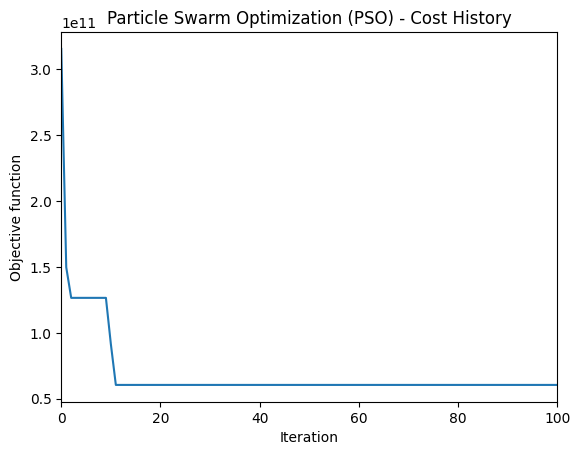

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 248308719214.60196


In [228]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

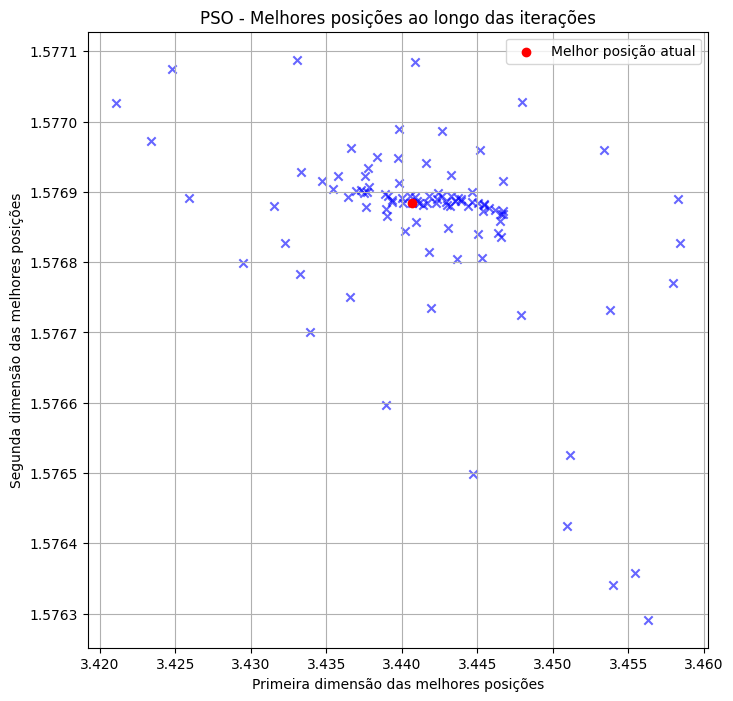

In [229]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()